In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


2.6.0+cu124
True
Tesla T4


In [2]:
!pip install spacy nltk --user
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 84.3 MB/s eta 0:00:00:00:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-um

# 1. IMPORT LIBS, DEPENDENCIES,... & SETUP ENVIRONMENT

## 1.1 Import all necessary dependencies

In [3]:
# Tokenizer
import spacy

# Build vocabulary
from collections import Counter

# Build model
import torch
import torch.nn as nn
import torch.optim as optim

# Load dataset for model
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# BLEU score
from nltk.translate.bleu_score import sentence_bleu

# Another (utils)
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"- Device for training: {device} - {torch.cuda.get_device_name(0)}")

- Device for training: cuda - Tesla T4


## 1.2 Connect to GG Drive

In [4]:
# from google.colab import drive
# drive.mount('/content/drive/')

# # Show the result
# dataset_path = "/content/drive/My Drive/021.SGU/01.Subjects/NLP/Dataset/"
# !ls "$dataset_path"

## 1.3 Set constant

In [5]:
# GGDRIVE_DATASET_DIR_PATH = "/content/drive/My Drive/021.SGU/01.Subjects/NLP/Dataset/"
# ----------------------------------------
""" [4] Build vocab
- <pad> - 0: padding, add to short sentences to have the same length with long sentences in Batch
- <unk> - 1: unknown, index for some unknown words (token)
- <sos> - 2: start of sentence
- <eos> - 3: end of sentence
"""
SPECIAL_TOKENS_CONST = ["<pad>", "<unk>", "<sos>", "<eos>"]
VOCAB_MAX_SIZE_CONST = 10000  # 10.000 most common words


#----- Change for optimize model -----#
#--- [DEFAULT] ~ [BASELINE]
# [5] Dataset & DataLoader
TRAIN_LOADER_BATCH_SIZE_DEFAULT     =   32
# [6] LSTM layers
LSTM_NUM_LAYERS_DEFAULT             =   2
LSTM_DROPOUT_DEFAULT                =   0.3
LSTM_TEACHER_FORCING_DEFAULT        =   0.5
LSTM_EMBED_DIM_DEFAULT              =   256
LSTM_HIDDEN_DIM_DEFAULT             =   512
# [7] TRAINING + VALIDATION + EARLY STOPPING
MODEL_LEARNING_RATE_DEFAULT         =   0.001
MODEL_EPOCHS_DEFAULT                =   20
MODEL_EARLY_STOP_PATIENCE_DEFAULT   =   3

#--- [V1: deeper LSTM layers]
# ...
# ...

#--- CURRENT ---#
TRAIN_LOADER_BATCH_SIZE_CURRENT = TRAIN_LOADER_BATCH_SIZE_DEFAULT
LSTM_NUM_LAYERS_CURRENT = LSTM_NUM_LAYERS_DEFAULT
LSTM_DROPOUT_CURRENT = LSTM_DROPOUT_DEFAULT
LSTM_TEACHER_FORCING_CURRENT = LSTM_TEACHER_FORCING_DEFAULT
LSTM_EMBED_DIM_CURRENT = LSTM_EMBED_DIM_DEFAULT
LSTM_HIDDEN_DIM_CURRENT = LSTM_HIDDEN_DIM_DEFAULT
MODEL_LEARNING_RATE_CURRENT = MODEL_LEARNING_RATE_DEFAULT
MODEL_EPOCHS_CURRENT = MODEL_EPOCHS_DEFAULT
MODEL_EARLY_STOP_PATIENCE_CURRENT = MODEL_EARLY_STOP_PATIENCE_DEFAULT
#-------------------------------------#




# 2. LOAD DATA

In [6]:
# from google.colab import drive
# drive.mount('/content/drive/')

# Show the result
# dataset_path = "/content/drive/My Drive/021.SGU/01.Subjects/NLP/Dataset/"
dataset_path = "/kaggle/input/nlp-machinetranslation-en-fr-multi30k"
!ls "$dataset_path"

def load_file(path):
    with open(path, 'r', encoding='utf-8') as file:
        # Remove abundant space at head/tail
        return [line.strip() for line in file]

train_en = load_file(f"{dataset_path}/train.en")
train_fr = load_file(f"{dataset_path}/train.fr")

val_en = load_file(f"{dataset_path}/val.en")
val_fr = load_file(f"{dataset_path}/val.fr")

test_en = load_file(f"{dataset_path}/test.en")
test_fr = load_file(f"{dataset_path}/test.fr")


print(f"- train.en size:    {len(train_en)}")
print(f"- train.fr size:    {len(train_fr)}")

print(f"- val.en size:    {len(val_en)}")
print(f"- val.fr size:    {len(val_fr)}")

print(f"- test.en size:    {len(test_en)}")
print(f"- test.fr size:    {len(test_fr)}")

print("-"*69)
print(f"- train.en example: {train_en[0]}")
print(f"- train.fr example: {train_fr[0]}")



test.en  test.fr  train.en  train.fr  val.en  val.fr
- train.en size:    29000
- train.fr size:    29000
- val.en size:    1014
- val.fr size:    1014
- test.en size:    1071
- test.fr size:    1071
---------------------------------------------------------------------
- train.en example: Two young, White males are outside near many bushes.
- train.fr example: Deux jeunes hommes blancs sont dehors près de buissons.


# 3. TOKENIZATION

In [7]:
# Load spacy's pre-trained models
nlp_en = spacy.load("en_core_web_sm")   # small English core, train with data in the internet
nlp_fr = spacy.load("fr_core_news_sm")  # small French core, train with news in French language

def en_tokenizer(text):
    # return lower token
    return [tok.text.lower() for tok in nlp_en.tokenizer(text)]
def fr_tokenizer(text):
    return [tok.text.lower() for tok in nlp_fr.tokenizer(text)]


In [8]:
# Tokenize our dataset files: train_en, train_fr, val_en, val_fr, test_en, test_fr.

train_en_tok = [en_tokenizer(sentence) for sentence in train_en]
train_fr_tok = [fr_tokenizer(sentence) for sentence in train_fr]

val_en_tok = [en_tokenizer(sentence) for sentence in val_en]
val_fr_tok = [fr_tokenizer(sentence) for sentence in val_fr]

test_en_tok = [en_tokenizer(sentence) for sentence in test_en]
test_fr_tok = [fr_tokenizer(sentence) for sentence in test_fr]



In [9]:
print(f"- train_en_tok: {train_en_tok[0]}")
print(f"- train_fr_tok: {train_fr_tok[0]}")
print(f"- val_en_tok: {val_en_tok[0]}")
print(f"- val_fr_tok: {val_fr_tok[0]}")
print(f"- test_en_tok: {test_en_tok[0]}")
print(f"- test_fr_tok: {test_fr_tok[0]}")


- train_en_tok: ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
- train_fr_tok: ['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']
- val_en_tok: ['a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck']
- val_fr_tok: ['un', 'groupe', "d'", 'hommes', 'chargent', 'du', 'coton', 'dans', 'un', 'camion']
- test_en_tok: ['a', 'young', 'man', 'participates', 'in', 'a', 'career', 'while', 'the', 'subject', 'who', 'records', 'it', 'smiles', '.']
- test_fr_tok: ['un', 'jeune', 'homme', 'participe', 'à', 'une', 'course', 'pendant', 'que', 'le', 'sujet', 'qui', 'le', 'filme', 'sourit', '.']


# 4. BUILD VOCABULARY

In [10]:
# Numericalization, word <--> index
class Vocab:
    def __init__(self, tokens, max_size=VOCAB_MAX_SIZE_CONST):
        # Get dictionary: {word, frequence}
        self.freq = Counter(tokens)
        # Get only VOCAB_MAX_SIZE words
        most_common = self.freq.most_common(max_size)

        # Set list words of SPECIAL_TOKENS and most_common words
        self.itos = SPECIAL_TOKENS_CONST + [word for word, _ in most_common]
        # Set dict for each items in the list above
        self.stoi = {word:idx for idx, word in enumerate(self.itos)}

    """ Numericalize:
        We only get VOCAB_MAX_SIZE = 10.000 (for special tokens and most common word),
        so some tokens in our dataset will not map this vocal (None for the result)
        Therefore, we have to map all token which is not existed in lists word(self.itos) be built above
        to <unk> - 1.

        return: numerical tokens
    """
    def numericalize(self, tokens):
        return [self.stoi.get(tok, self.stoi.get('<unk>')) for tok in tokens]

    def __len__(self):
        return len(self.itos)

vocab_en = Vocab(tok for sentence in train_en_tok for tok in sentence)
vocab_fr = Vocab(tok for sentence in train_fr_tok for tok in sentence)

# Get some special index
PAD_IDX = vocab_fr.stoi.get('<pad>')
SOS_IDX = vocab_fr.stoi.get('<sos>')
EOS_IDX = vocab_fr.stoi.get('<eos>')


In [11]:
print(vocab_en.itos[0:10])
print("- Index of 'man': ",vocab_en.stoi.get('not-in-vocab'))

print()
print(f"- <pad> index: {PAD_IDX}")
print(f"- <sos> index: {SOS_IDX}")
print(f"- <eos> index: {EOS_IDX}")

['<pad>', '<unk>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']
- Index of 'man':  None

- <pad> index: 0
- <sos> index: 2
- <eos> index: 3


# 5. DATASET & DATALOADER


In [12]:
class TranslationDataset(Dataset):
    def __init__(self, train_en_tok, train_fr_tok, vocab_en, vocab_fr):
        self.en = train_en_tok
        self.fr = train_fr_tok
        self.vocab_en = vocab_en
        self.vocab_fr = vocab_fr

    def __len__(self):
        return len(self.en)

    def __getitem__(self, idx):
        # Insert padding: <sos> and <eos>
        en_tokens = ["<sos>"] + self.en[idx] + ["<eos>"]
        fr_tokens = ["<sos>"] + self.fr[idx] + ["<eos>"]

        en_idx_in_vocab_en = self.vocab_en.numericalize(en_tokens)
        fr_idx_in_vocab_fr = self.vocab_fr.numericalize(fr_tokens)

        # return a tuple tensor index
        return torch.tensor(en_idx_in_vocab_en), torch.tensor(fr_idx_in_vocab_fr)

# Padding for short sentences in each batch
def collate_fn(batch):
    # Split sequence to english sentence and french sentence
    en_batch, fr_batch = zip(*batch)

    """ Padding:
        1. Find the max length
        2. Insert <pad> - 0 to the tail of short sentences. e.g:
            First 1: [1, 10, 11, 12, 2] (keep, the longest sentence)
            Second 2: [1, 13, 2, **0**, **0**] (append two <pad>-0)
        3. Stacking (by columns: column - batch, row - timestep)
                    1   1
                    10  13
                    11  2
                    12  0
                    2   0
    """
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
    fr_batch = pad_sequence(fr_batch, padding_value=PAD_IDX)

    return en_batch, fr_batch

def collate_fn_with_real_length(batch):
    en_batch, fr_batch = zip(*batch)

    # 1. Get real length before padding
    en_lens = [len(x) for x in en_batch]
    fr_lens = [len(x) for x in fr_batch]

    # 2. Padding
    en_pad = pad_sequence(en_batch, padding_value=PAD_IDX)
    fr_pad = pad_sequence(fr_batch, padding_value=PAD_IDX)

    # 3. Return padded sequence and real length
    return en_pad, fr_pad, torch.tensor(en_lens), torch.tensor(fr_lens)


train_dataset = TranslationDataset(train_en_tok, train_fr_tok, vocab_en, vocab_fr)
val_dataset = TranslationDataset(val_en_tok, val_fr_tok, vocab_en, vocab_fr)
test_dataset = TranslationDataset(test_en_tok, test_fr_tok, vocab_en, vocab_fr)


# For train dataset, we should shuffle it to avoid overfitting.
train_loader = DataLoader(train_dataset, batch_size=TRAIN_LOADER_BATCH_SIZE_CURRENT, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_LOADER_BATCH_SIZE_CURRENT, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)




In [13]:
# shape: [Sequence_Length, Batch_Size], because LSTM/RNN in Pytorch handle data by timestep
batch_train_en, batch_train_fr = next(iter(train_loader))
batch_val_en, batch_val_fr = next(iter(val_loader))
batch_test_en, batch_test_fr = next(iter(test_loader))

print(f"{batch_train_en.shape} - {batch_train_en.shape}")
print(f"{batch_val_en.shape} - {batch_val_fr.shape}")
print(f"{batch_test_en.shape} - {batch_test_fr.shape}")


torch.Size([22, 32]) - torch.Size([22, 32])
torch.Size([27, 32]) - torch.Size([27, 32])
torch.Size([17, 1]) - torch.Size([18, 1])


# 6. ENCODER-DECODER, SEQ2SEQ MODEL

In [14]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=LSTM_NUM_LAYERS_DEFAULT, dropout=LSTM_DROPOUT_DEFAULT):
        super().__init__()

        # src shape e.g: [10, 32] - [Sequence_length, Batch_size]
        """ embed_dim: vector size for each word
            - Create matrix (A) with shape: [vocab_size, embed_dim], each row represent for each word,
            e.g: src shape: [10, 32], elements are the index of words in vocab, so we get the row of that index in matrix (A)
            - Result: a matrix with shape [10, 32, 256]
        """
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        """ hidden_dim: vector size for hidden state
            - Result: e.g [10, 32, 512]
        """
        self.lstm = nn.LSTM(embed_dim, hidden_dim,
                            num_layers=num_layers,  # use num_layers(2) layers LSTM
                            dropout=dropout)    # randomly turn off neuron to avoid overfitting
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=LSTM_NUM_LAYERS_DEFAULT, dropout=LSTM_DROPOUT_DEFAULT):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim,
                            num_layers=num_layers,
                            dropout=dropout)
        # Fully connected
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, hidden, cell):
        # input: a word
        # LSTM require input shape: [Seq_Len, Batch, Dim]
        # We handle 1 word each timestep so, Seq_Len=1
        input = input.unsqueeze(0)
        # embedding, shape: [1, 32, 256]
        embedded = self.embedding(input)

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))

        # sequeeze(0): remove 1 in [1, 32, 256], then push to fully connected
        # prediction shape: [32, 10000], the probability of 10.000 vocab_fr
        prediction = self.fc(output.squeeze(0))

        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing=LSTM_TEACHER_FORCING_DEFAULT):
        # src (en): [src_len, batch_size]
        # trg (fr): [trg_len, batch_size]

        batch_size = trg.size(1)
        max_len = trg.size(0)
        vocab_size = self.decoder.fc.out_features

        # a zero tensor (default) contain output
        outputs = torch.zeros(max_len, batch_size, vocab_size).to(src.device)

        # Get Context Vector from Encoder:
        hidden, cell = self.encoder(src)
        # token <sos>
        input_token = trg[0, :]

        for timestep in range(1, max_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell)
            outputs[timestep] = output

            best_guess = output.argmax(1)

            # teacher_forcing:
            # random < teacher_forcing ratio: trg[timestep], the true target
            # random >= teacher_forcing ratio: the best_guess
            input_token = trg[timestep] if random.random() < teacher_forcing else best_guess

        return outputs



# 7. TRAINING + VALIDATION + EARLY STOPPING

In [15]:
start_time = time.perf_counter()


input_dim = len(vocab_en)
output_dim = len(vocab_fr)
# print(input_dim, output_dim)

encoder = Encoder(vocab_size=input_dim, embed_dim=LSTM_EMBED_DIM_CURRENT, hidden_dim=LSTM_HIDDEN_DIM_CURRENT, num_layers=LSTM_NUM_LAYERS_CURRENT).to(device)  # 256, 512
decoder = Decoder(vocab_size=output_dim, embed_dim=LSTM_EMBED_DIM_CURRENT, hidden_dim=LSTM_HIDDEN_DIM_CURRENT, num_layers=LSTM_NUM_LAYERS_CURRENT).to(device)  # 256, 512

model = Seq2Seq(encoder, decoder).to(device)

# Ignore computing loss for PAD_IDX
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(params=model.parameters(), lr=MODEL_LEARNING_RATE_CURRENT)

def evaluate(model, loader):
    model.eval()
    total = 0
    # torch.no_grad(): remove old gradient
    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(device), trg.to(device)
            outputs = model(src, trg, teacher_forcing=LSTM_TEACHER_FORCING_CURRENT)

            loss = criterion(outputs[1:].reshape(-1, outputs.size(-1)),
                             trg[1:].reshape(-1))

            total += loss.item()
    return total / len(loader)

best_val = float("inf")
best_state_dict = None
best_epoch = -1
wait = 0

val_loss_arr = []
train_loss_arr = []

for epoch in range(MODEL_EPOCHS_CURRENT):
    model.train()
    total_loss = 0

    for src, trg in tqdm(train_loader):
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        outputs = model(src, trg)

        loss = criterion(outputs[1:].reshape(-1, outputs.size(-1)),
                        trg[1:].reshape(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    val_loss = evaluate(model, val_loader)

    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)

    print(f"Epoch {epoch + 1} | Train = {train_loss:.4f} | Val = {val_loss:.4f}\n")

    if val_loss < best_val:
        best_val = val_loss
        best_state_dict = model.state_dict()
        best_epoch = epoch
        wait = 0
        # torch.save(model.state_dict(), "best_model.pth")
    else:
        wait += 1
        if wait >= MODEL_EARLY_STOP_PATIENCE_CURRENT:
            print("\n[X] Early stopping triggered!\n")
            break

# Save the best model
torch.save(best_state_dict, "best_model.pth")
print(f"- Best model saved at epoch {best_epoch+1}, val_loss={best_val:.4f}")

end_time = time.perf_counter()
print(f"--- DONE ---!\n- Total training time: {end_time- start_time:.2f} seconds.")

100%|██████████| 907/907 [01:22<00:00, 10.95it/s]


Epoch 1 | Train = 4.6701 | Val = 3.9814



100%|██████████| 907/907 [01:19<00:00, 11.38it/s]


Epoch 2 | Train = 3.7443 | Val = 3.4211



100%|██████████| 907/907 [01:18<00:00, 11.50it/s]


Epoch 3 | Train = 3.3258 | Val = 3.1537



100%|██████████| 907/907 [01:17<00:00, 11.72it/s]


Epoch 4 | Train = 2.9846 | Val = 2.9786



100%|██████████| 907/907 [01:16<00:00, 11.86it/s]


Epoch 5 | Train = 2.6973 | Val = 2.7816



100%|██████████| 907/907 [01:19<00:00, 11.47it/s]


Epoch 6 | Train = 2.4684 | Val = 2.6826



100%|██████████| 907/907 [01:17<00:00, 11.72it/s]


Epoch 7 | Train = 2.2393 | Val = 2.6347



100%|██████████| 907/907 [01:18<00:00, 11.51it/s]


Epoch 8 | Train = 2.0583 | Val = 2.5449



100%|██████████| 907/907 [01:17<00:00, 11.70it/s]


Epoch 9 | Train = 1.8875 | Val = 2.5233



100%|██████████| 907/907 [01:17<00:00, 11.73it/s]


Epoch 10 | Train = 1.7218 | Val = 2.5706



100%|██████████| 907/907 [01:17<00:00, 11.64it/s]


Epoch 11 | Train = 1.5903 | Val = 2.5334



100%|██████████| 907/907 [01:17<00:00, 11.74it/s]


Epoch 12 | Train = 1.4484 | Val = 2.5619


[X] Early stopping triggered!

- Best model saved at epoch 9, val_loss=2.5233
--- DONE ---!
- Total training time: 954.14 seconds.


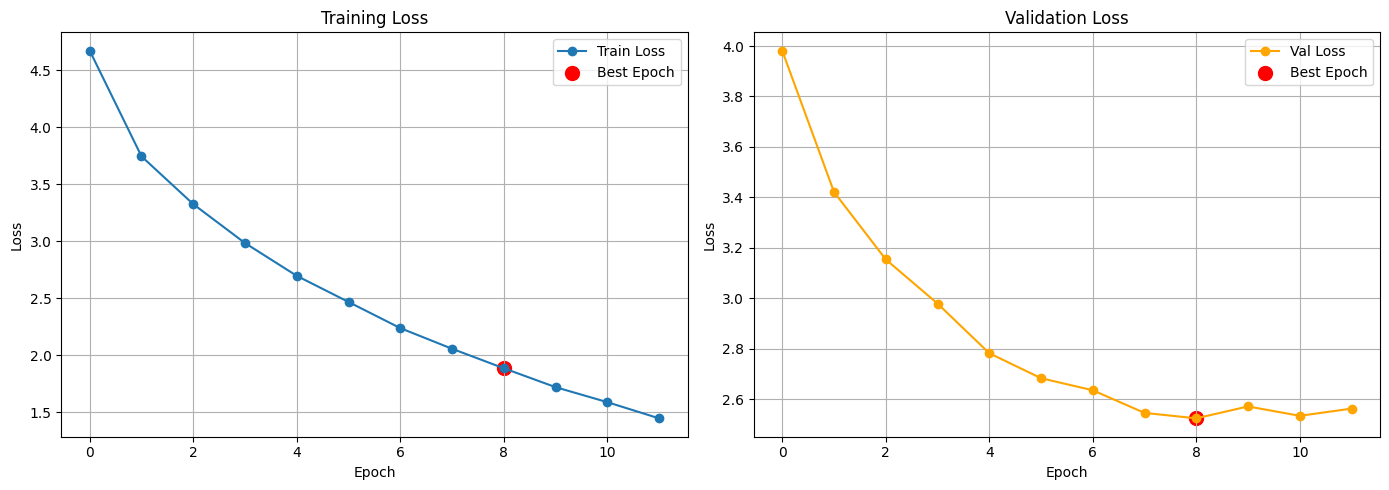

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# 1. Train Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_arr, marker='o', label="Train Loss")
plt.scatter(best_epoch, train_loss_arr[best_epoch], color='red', s=100,
            label="Best Epoch")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# 2. Validation Loss Plot
plt.subplot(1, 2, 2)
plt.plot(val_loss_arr, color='orange', marker='o', label="Val Loss")
plt.scatter(best_epoch, val_loss_arr[best_epoch], color='red', s=100,
            label="Best Epoch")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# 8. TRANSLATE + BLEU SCORE

In [17]:
def translate(sentence):
    model.eval()

    # tokenize
    tokens = en_tokenizer(sentence)

    # tạo vector số hóa đúng chuẩn
    ids = (
        [vocab_en.stoi["<sos>"]] +
        [vocab_en.stoi.get(t, vocab_en.stoi["<unk>"]) for t in tokens] +
        [vocab_en.stoi["<eos>"]]
    )

    src = torch.tensor(ids).unsqueeze(1).to(device)

    with torch.no_grad():
        hidden, cell = model.encoder(src)

    # token đầu tiên đầu ra
    input_tok = torch.tensor([vocab_fr.stoi["<sos>"]]).to(device)
    outputs = []

    for _ in range(50):
        with torch.no_grad():
            pred, hidden, cell = model.decoder(input_tok, hidden, cell)

        top_id = pred.argmax(1).item()

        if top_id == vocab_fr.stoi["<eos>"]:
            break

        outputs.append(top_id)
        input_tok = torch.tensor([top_id]).to(device)

    return " ".join(vocab_fr.itos[i] for i in outputs)


In [18]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu():
    references = []   # dạng: [[ref_tokens], [ref_tokens], ...]
    hypotheses = []   # dạng: [pred_tokens, pred_tokens, ...]

    for en, fr in zip(test_en_tok, test_fr_tok):
        # input cho model là chuỗi tiếng Anh
        pred = translate(" ".join(en))

        # BLEU yêu cầu:
        #   - ref: list các câu tham chiếu → mỗi câu phải bọc trong 1 list
        #   - hyp: list các câu dự đoán tokenized
        references.append([fr])
        hypotheses.append(pred.split())

    score = corpus_bleu(
        references,
        hypotheses,
        weights=(0.25, 0.25, 0.25, 0.25)
    )
    return score


model.load_state_dict(torch.load("best_model.pth"))
bleu = evaluate_bleu()
print("Corpus BLEU on Test =", bleu)



Corpus BLEU on Test = 0.15370784970143664


In [1]:
test = translate("It looks like something went wrong with your recent email to support.")
print(test)
test = translate("The man is scratching the back of his neck while looking for a book in a book store")
print(test)

NameError: name 'translate' is not defined